## Modèle GARCH sur les contrats futures S&P500 (E-minis - ES)

Afin d'élaborer notre stratégie de trading à partir du modèle prédictif (ARIMA/GARCH) nous allons d'abord réaliser une prédiction des E-minis avec le modèle GARCH.

Pour ce faire nous passerons par 4 étapes :

1. Le sourcing des futures S&P500 (E-minis)
2. La conception des visualisations des simulations
3. La simulation du processus stochastique GARCH
    * La détermination du critère d'information d'Akaike (AIC)
    * Le tableau des résultats
    * Le data fitting avec le test de Ljung-Box
    * La vérification de la normalité avec le test de Kolmogorov-Smirnov
4. La prédiction et backtesting du modèle

Commençons par importer les librairies utilisées :

In [24]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from arch import arch_model

from sklearn.metrics import mean_squared_error

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

### Le sourcing des futures S&P500 (E-minis)

Le sourcing des données porte sur les futures S&P500 (E-minis) du **18 septembre 2000 à aujourd'hui**. 

Pour faire fonctionner notre modèle nous utiliserons :

- **80 % de données d'entrainement (jusqu'au 18 septembre 2016 ~ 4067 données)** 
- **20 % de données de test (du 19 septembre 2016 à aujourd'hui ~ 1017 données)**.

Nous sourçons nos données grâce à notre fournisseur **Yahoo Finance** qui nous permet d'exploiter environ **5084 données**.

In [2]:
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
startDateStr = '2000/09/18'
endDateStr = '2020/09/18'
cachedFolderName = 'yahooData/'
dataSetId = 'Futures_ES_2000_2020'
instrumentIds = ['ES=F']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']

# log returns
lrets = np.log(data/data.shift(1))

Processing data for stock: ES=F
20% done...
40% done...
60% done...
80% done...


In [3]:
# Selection/Exploration des données sourcées
# Séparation des données d'entrainement et de test

TStraining = lrets['ES=F'].iloc[0:4068].dropna()
TStraining.index = pd.DatetimeIndex(TStraining.index.values, freq=TStraining.index.inferred_freq)

TStest = lrets['ES=F'].iloc[4067:].dropna()
TStest.index = pd.DatetimeIndex(TStest.index.values, freq=TStest.index.inferred_freq)

#### Pourquoi utiliser le logarithme des rendements ?

Commençons par définir un retour : $r_i$ au moment $i$, où $pi$ est le prix au moment $i$ et $j \equiv (i - 1)$ :

$$r_i = \frac {p_i - p_j}{p_j}$$
   

L'avantage de l'utilisation des ***rendements*** , par rapport aux prix, est la ***normalisation*** : mesurer toutes les variables dans une métrique comparable, permettant ainsi l'évaluation des relations analytiques entre deux ou plusieurs variables bien qu'elles proviennent de séries de prix de valeurs inégales. C'est une exigence pour de nombreuses techniques d'analyse statistique multidimensionnelle et d'apprentissage automatique. Par exemple, l'interprétation d'une matrice de covariance d'équité est rendue sensée lorsque les variables sont toutes deux mesurées en pourcentage.

Plusieurs avantages de l'utilisation des ***retours de log***, à la fois théoriques et algorithmiques.

Premièrement, la ***normalité logarithmique*** : si nous supposons que les prix sont distribués log normalement (ce qui, en pratique, peut ou non être vrai pour une série de prix donnée), alors $log(1 + r_i)$ est commodément distribué normalement, car:

$$1 + r_i = \frac{p_i}{p_j} = \exp^{\log(\frac{p_i}{p_j})}$$  

C'est pratique étant donné que la plupart des statistiques classiques présument la normalité.

Deuxièmement, ***l'égalité approximative du log brut*** : lorsque les rendements sont très faibles (courant pour les transactions avec des durées de détention courtes), l'approximation suivante garantit qu'ils sont proches en valeur des rendements bruts:

$$\log(1 + r) \approx r $$avec$$ r \ll 1$$ 

Troisièmement, ***l'additivité au temps*** : considérez une séquence ordonnée de $n$ transactions. Une statistique fréquemment calculée à partir de cette séquence est le ***rendement composé***, qui est le rendement courant de cette séquence de transactions au fil du temps :

$$\displaystyle(1 + r_1)(1 + r_2)\cdots(1 + r_n) = \prod_i(1 + r_i)$$

Cette formule est assez désagréable, car la théorie des probabilités nous le rappelle que le produit de variables normalement distribuées n'est pas normal. Au lieu de cela, la somme des variables normalement distribuées est normale (technicité importante: uniquement lorsque toutes les variables ne sont pas corrélées ), ce qui est utile lorsque l'on rappelle l'identité logarithmique suivante :

$$\log (1 + r_i) = log (\frac {p_i}{p_j}) = \log (p_i) - log (p_j)$$ 

Ainsi, les rendements composés sont normalement distribués. Enfin, cette identité nous conduit à un bénéfice algorithmique agréable; une formule simple pour calculer les rendements composés:

$$\displaystyle \sum_i \log (1 + r_i) = \log (1 + r_1) + \log (1 + r_2) + \cdots + \log (1 + r_n) = \log (p_n) - \log (p_0)$$

Ainsi, le rendement composé sur $n$ périodes est simplement la différence de log entre les périodes initiale et finale. En termes de complexité algorithmique , cette simplification réduit O (n) multiplications à O (1) additions. C'est une énorme victoire pour n modéré à grand. En outre, cette somme est utile pour les cas où les rendements divergent de la normale, car le ***théorème de la limite centrale*** nous rappelle que la moyenne de l'échantillon de cette somme convergera vers la normalité (en supposant des premier et deuxième moments finis).

Quatrièmement, la ***facilité mathématique*** : du calcul, on nous rappelle (en ignorant la constante d'intégration) :

$$e ^ x = \int e ^ x dx = \frac {d}{dx} e ^ x = e ^ x$$ 

Cette identité est extrêmement utile, car une grande partie des mathématiques financières est construite sur des ***processus stochastiques en temps continu*** qui reposent fortement sur l'intégration et la différenciation.

Cinquièmement, la stabilité numérique : l'addition de petits nombres est numériquement sûre, alors que la multiplication de petits nombres ne l'est pas car elle est sujette à un ***dépassement arithmétique***. Pour de nombreux problèmes intéressants, il s'agit d'un problème potentiel sérieux. Pour résoudre ce problème, soit l'algorithme doit être modifié pour être numériquement robuste, soit il peut être transformé en une somme numériquement sûre via des journaux.

### La conception des visualisations des simulations

La fonction ci-dessous nous permet d'afficher 5 graphiques : 

- **La série temporelle**
- **L'ACF**
- **Le PACF**
- **Le diagramme Quantile-Quantile**
- **La courbe de probabilité normale**

Le **PACF** est une **corrélation partielle** entre les résidus, qui tient compte des délais plus courts. L'axe des $x$ indique les valeurs du décalage, $k$ et la région ombrée en bleu indique les **limites de signification**. Seules les valeurs qui se situent en dehors de la région bleue sont **significatives**.

Le **diagramme Quantile-Quantile** compare deux distributions de probabilité en traçant leurs quantiles l'un par rapport à l'autre. Si les deux distributions sont similaires (ou linéairement liées), les points du tracé Q-Q se situeront approximativement sur une ligne. Nous comparons la distribution de nos résidus avec une distribution normale.

La **courbe de probabilité** normale évalue également si un ensemble de données est ou non distribué approximativement normalement. Les données sont tracées par rapport à une distribution normale théorique de telle manière que les points doivent former une ligne droite approximative. Les écarts par rapport à cette ligne droite indiquent des écarts par rapport à la normalité.

In [4]:
def tsplot(y, lags=None, figsize=(12, 8), style='seaborn-darkgrid'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    #Configuration des graphiques
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
    #Réalisation des graphiques
            
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

### La simulation du processus stochastique GARCH (p,q)

Tout comme ARCH (p) est AR (p) appliqué à la variance d'une série chronologique, **GARCH (p, q)** est un modèle ARMA (p, q) appliqué à la **variance** d'une série chronologique. 
L'AR (p) modélise la variance des résidus (erreurs au carré) ou simplement notre série chronologique au carré. La partie MA (q) modélise la variance du processus.

#### La détermination du critère d'information d'Akaike (AIC)

Le critère **AIC** est une **mesure de la qualité d'un modèle statistique**. Il s’applique aux modèles estimés par un **maximum de vraisemblance** : les analyses de variance, les régressions linéaires multiples, les régressions logistiques et de Poisson peuvent rentrer dans ce cadre. Il utilise ce maximum tout en pénalisant les modèles comportant trop de variables, qui **surapprennent** les données et généralisent mal.

Le critère AIC est défini par : $$AIC = −2 log (L) + 2k$$ 

où $L$ est la vraisemblance maximisée et $k$ le nombre de paramètres dans le modèle. 

Avec ce critère, la déviance du modèle $−2 log (L)$ est pénalisée par **2 fois** le nombre de paramètres.

L’AIC représente donc un compromis entre le **biais**, diminuant avec le nombre de paramètres, et la **parcimonie**, volonté de décrire les données avec le plus petit nombre de paramètres possibles. 

- La rigueur voudrait que tous les modèles comparés dérivent tous d’un même « complet » inclus dans la liste des modèles comparés.
- Il est nécessaire de vérifier que les conditions d’utilisation du modèle complet et de celui sélectionné sont remplies.
- Le **meilleur modèle** est celui possédant l’AIC le plus **faible**.

Maintenant, nous pouvons ajuster le modèle **GARCH** en utilisant les meilleurs paramètres d'ajustement du modèle ARIMA

In [115]:
# Précision des hypothèses du modèle GARCH
garch = arch_model(TStraining, mean='zero', vol='GARCH', p=3, o=0, q=3, dist='skewt', rescale=False)

# Fit le modèle
garch_fit = garch.fit(disp='off')

#### Le tableau des résultats

In [116]:
print(garch_fit.summary())

                             Zero Mean - GARCH Model Results                             
Dep. Variable:                              ES=F   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -222649.
Distribution:      Standardized Skew Student's t   AIC:                           445316.
Method:                       Maximum Likelihood   BIC:                           445373.
                                                   No. Observations:                 4067
Date:                           Sat, Jan 16 2021   Df Residuals:                     4058
Time:                                   09:54:43   Df Model:                            9
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------

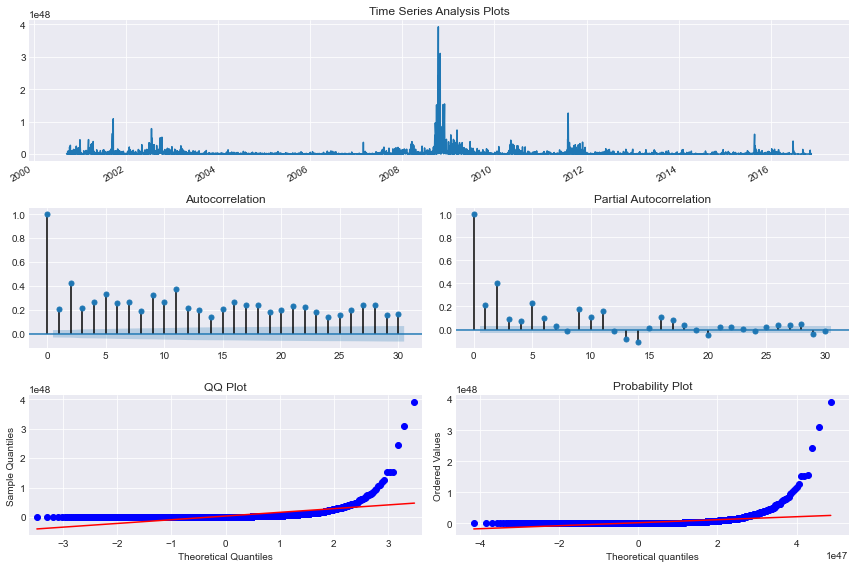

In [117]:
tsplot(garch_fit.resid ** 2, lags=30)

#### Le data fitting avec le test de Ljung-Box

Le test de **Ljung-Box** est un test statistique qui teste **l'auto-corrélation d'ordre supérieur à 1** (dépendance des valeurs résiduelles). Il peut être défini comme :

$H_0$ (hypothèse nulle) : les données sont distribuées **indépendamment** (les corrélations dans la population à partir desquelles l'échantillon est prélevé sont égales à 0, de sorte que toute corrélation observée dans les données résulte du caractère aléatoire du processus d'échantillonnage).

$H_a$ (hypothèse alternative) : les données ne sont pas distribuées indépendamment; elles présentent une **corrélation** en série.

La statistique du test est:

$$Q = n\left(n+2\right)\sum_{k=1}^h\frac{\hat{\rho}^2_k}{n-k}$$

où $n$ est la taille de l'échantillon, $\hat{\rho}_k$ est l'autocorrélation de l'échantillon au décalage $k$ , et $h$ est le nombre de décalages testés. En dessous de $H_0$ la statistique $Q$ suit asymptotiquement un $\chi _{{(h)}}^{2}$. 

Pour le niveau de signification $\alpha$, la région critique pour le rejet de l'hypothèse du caractère aléatoire est:
$Q > \chi_{1-\alpha,h}^2$ où $\chi_{1-\alpha,h}^2$ est le quantile $1 - \alpha$ de la distribution $\chi_{2}$ avec $h$ degrés de liberté.


Dans notre cas, on retrouve en paramètre notre meilleur modèle : **GARCH (3,0,3)**. Le test est appliqué aux résidus d'un modèle ARIMA ajusté, et non à la série d'origine, et dans de telles applications, l'hypothèse $H_0$ actuellement testée est que **les résidus du modèle ARIMA n'ont pas d'autocorrélation** (contrairement à l'hypothèse $H_0$ du test Ljung-Box général). 

Lors du test des résidus d'un modèle ARIMA estimé, les degrés de liberté doivent être ajustés pour refléter l'estimation des paramètres. Par exemple, pour un modèle GARCH (p, 0, q), les degrés de liberté doivent être définis sur $h$ - $p$ - $q$.

De ce test nous sommes censé obtenir la **statistique du test** et la **p-value**.

Si la **p-value** < $0,05$ : Nous **rejetons l'hypothèse nulle** en supposant qu'il y 5% de chances de faire une erreur. Nous supposons que nos valeurs montrent une **dépendance** les unes envers les autres.

Si la **p-value** > $0,05$ : Nous n'avons pas suffisamment de preuves statistiques pour rejeter l'hypothèse nulle. Nous ne pouvons donc pas supposer que nos valeurs sont dépendantes. Cela peut signifier que nos valeurs sont **indépendantes** ou qu'elles **dépendent de toute façon**. En effet, nous ne pouvons pas prouver de possibilités spécifiques, c'est à dire que nous ne pouvons pas affirmer la dépendance des valeurs, ni affirmer l'indépendance des valeurs (non confirmation de l'hypothèse nulle).


Comme expliqué au début, nous ne pouvons pas prouver l'indépendance des valeurs des séries temporelles à l'aide du test Ljung-Box mais **seulement** la dépendance.

In [118]:
# Data fitting avec Ljung-Box
# Décalage 20

sms.diagnostic.acorr_ljungbox(garch_fit.resid, lags=[20], boxpierce=False, return_df=True, model_df=14)

,lb_stat,lb_pvalue
20,70.715941,2.915589e-13


#### La vérification de la normalité avec le test de Kolmogorov-Smirnov

En statistiques, le test de **Kolmogorov-Smirnov** est un test d'hypothèse utilisé pour déterminer si un échantillon suit bien une loi donnée connue par sa **fonction de répartition continue**, ou bien si deux échantillons suivent la même loi. Nous allons vérifier grâce à ce test si notre modèle est **normalement** distribué.


L'hypothèse nulle est : $H_0$: la loi $P$ a pour fonction de répartition $F_0$


où $F_0$ est la fonction de répartition d'une loi continue donnée.


L'idée est la suivante : si l'hypothèse $H_0$ est correcte, alors la fonction de répartition empirique $\widehat{F}$ de l'échantillon doit être proche de $F_0$.


La fonction de repartition empirique est la fonction de $\mathbb{R}$ dans [0,1], qui vaut :
$$
\widehat{F}(x) =
\begin{cases}
0 \; pour \; x < X_{(1)} \\
\text{...} \\
\frac{i}{n} \;
pour \; X_{(i)}\leq x < X_{(i+1)}\\
\text{ ... }\\
1 \; pour \; x \ge X_{(n)}
\end{cases}
$$


où les $ X_{(i)}$ sont les statistiques d'ordre de l'échantillon (valeurs de l'échantillon rangées par ordre croissant). En d'autres termes, $ \widehat{F}(x)$ est la proportion d'éléments de l'échantillon qui sont inférieurs ou égaux à $ x$.


On mesure l'adéquation de la fonction de répartition empirique à la fonction $ F_0$ par la distance de Kolmogorov-Smirnov, qui est la distance de la norme uniforme entre fonctions de répartitions. Pour la calculer, il suffit d'évaluer la différence entre $ \widehat{F}$ et $ F_0$ aux points $ X_{(i)}$.


$$ D_{KS}(F_0,\widehat{F}) = \max_{i=1,\ldots,n}\left\{\; \middle| F_0 (X_{(i)}) - \frac{i}{n}\middle| \; , \;  \middle| F_0 (X_{(i)}) -\frac{i-1}{n}\middle| \; \right\}.
$$

In [119]:
# Test de normalité

from statsmodels.stats.diagnostic import kstest_normal

score, pvalue = kstest_normal(garch_fit.resid)

if pvalue > 0.10:
    print('La p-value est de {}. Le résidu ne semble pas normalement distribué.'.format(pvalue))
else:
    print('La p-value est de {}. Le résidu semble être distribué normalement.'.format(pvalue))

La p-value est de 3.782581158541961e-96. Le résidu semble être distribué normalement.


###  Le diagnostique du modèle

Le diagnostique du modèle nous permet de comparer les valeurs prédites aux valeurs réelles de la série chronologique, ce qui nous aidera à comprendre l'**exactitude de nos prévisions** et le **pouvoir prédictif** du modèle.

In [120]:
# Obtenir la volatilité estimée du modèle
garch_vol = garch_fit.conditional_volatility

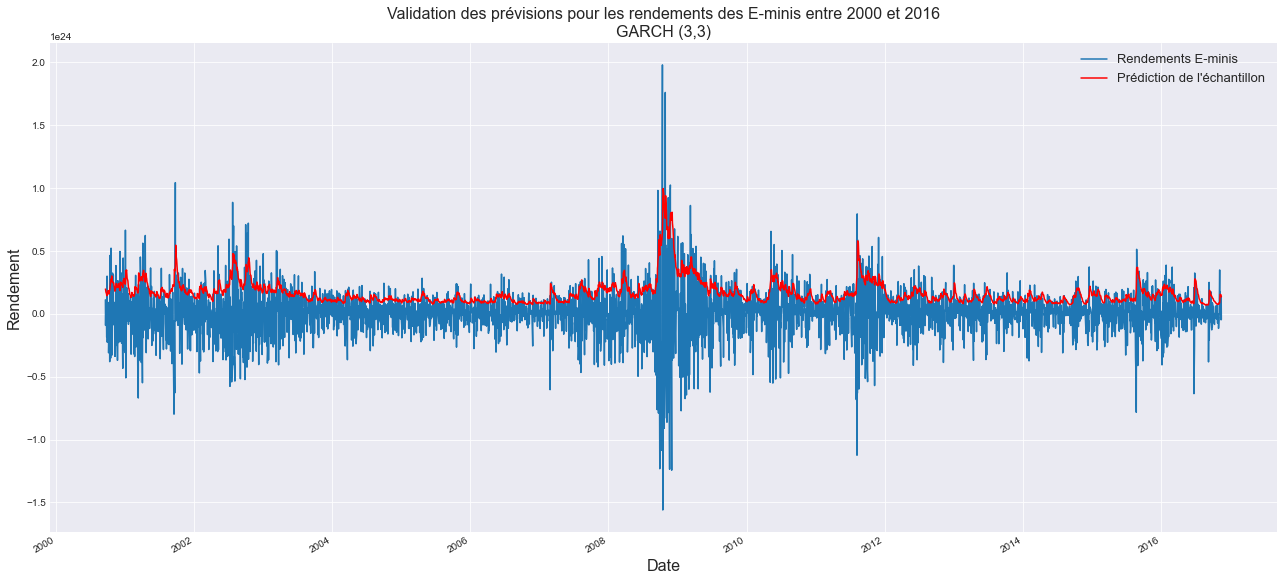

In [121]:
# Configuration du graphique

plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(22,10))
ax = plt.gca()
graph = TStraining.plot(ax=ax, label='Rendements E-minis')
graph.set_xlabel('Date', fontsize=16)
graph.set_ylabel('Rendement', fontsize=16)

# Prévision de l'échantillon

garch_vol.plot(ax=ax, style='r-', label='Prédiction de l\'échantillon')

plt.title('Validation des prévisions pour les rendements des E-minis entre 2000 et 2016\nGARCH (3,3)', fontsize=16)
plt.legend(loc='best', fontsize=13)

### L'estimation de sa précision

Il est utile de quantifier l'exactitude de nos prévisions. Nous utilisons l'**erreur quadratique moyenne**, qui résume l'erreur moyenne de nos prévisions. Pour chaque valeur prédite, nous calculons sa **distance** par rapport à la vraie valeur et la quadrature du résultat. Les résultats doivent être mis au **carré** afin que les différences positives / négatives ne s'annulent pas lorsque nous calculons la moyenne globale. Plus l'erreur quadratique moyenne est proche de **0** plus notre modèle est **précis**.

In [122]:
def evaluate(observation, forecast): 
    
    # Appel de la fonction
    mse = mean_squared_error(observation, forecast)
    print(f'Mean Squared Error (MSE): {mse}')
    return

# Backtest avec MSE
evaluate(TStraining.sub(TStraining.mean()).pow(2), garch_vol**2)

Mean Squared Error (MSE): 1.2201341419636116e+94


### La prédiction et backtesting du modèle

Lorsque l'on utilise des prévisions basées sur la simulation ou le bootstrap, un attribut supplémentaire d'un objet ARCHModelForecast est significatif : la simulation. 

Les prévisions fondées sur le bootstrap sont presque identiques aux prévisions fondées sur la simulation, sauf que les valeurs utilisées pour simuler le processus sont calculées à partir de données historiques plutôt qu'en utilisant la distribution supposée des résidus. Les prévisions produites à l'aide de cette méthode renvoient également un modèle ARCHModelForecastSimulation contenant des informations sur les trajectoires simulées.

In [123]:
# Les pistes pour l'observation finale
sim_forecasts = garch_fit.forecast(horizon=5, method='simulation')
sim_paths = sim_forecasts.simulations.residual_variances[-1].T
sim = sim_forecasts.simulations

bs_forecasts = garch_fit.forecast(horizon=5, method='bootstrap')
bs_paths = bs_forecasts.simulations.residual_variances[-1].T
bs = bs_forecasts.simulations

#### Comparaison des simulations

Les chemins sont disponibles sur les simulations d'attributs. Le tracé des chemins montre des différences importantes entre les deux scénarios au-delà des différences moyennes. Les deux commencent au même point.

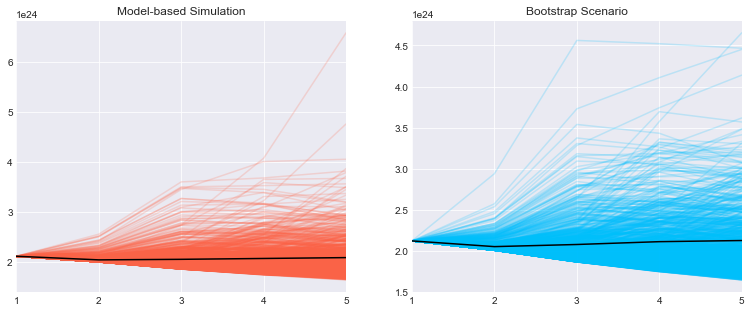

In [124]:
fig, axes = plt.subplots(1, 2, figsize=(13,5))

x = np.arange(1, 6)

# Trace les chemins et la moyenne et fixe l'axe pour avoir la même limite
axes[0].plot(x, np.sqrt(252 * sim_paths), color='tomato', alpha=0.2)
axes[0].plot(x, np.sqrt(252 * sim_forecasts.residual_variance.iloc[-1]),
    color='k', alpha=1)

axes[0].set_title('Model-based Simulation')
axes[0].set_xticks(np.arange(1, 6))
axes[0].set_xlim(1, 5)

axes[1].plot(x, np.sqrt(252 * bs_paths), color='deepskyblue', alpha=0.2)
axes[1].plot(x,np.sqrt(252 * bs_forecasts.residual_variance.iloc[-1]),
    color='k', alpha=1)

axes[1].set_xticks(np.arange(1, 6))
axes[1].set_xlim(1, 5)

axes[1].set_title('Bootstrap Scenario')
plt.show()

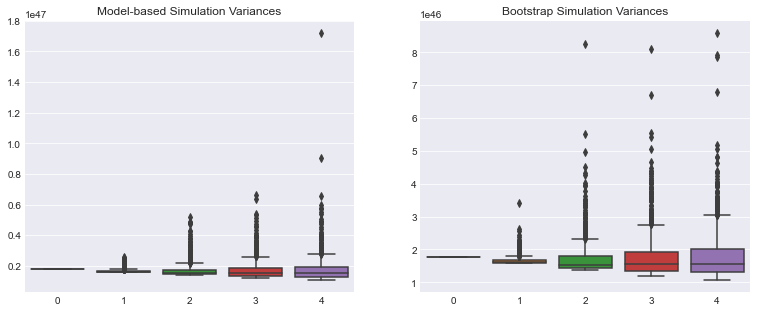

In [125]:
# Écarts de simulation de tracé
fig, axes = plt.subplots(1, 2, figsize=(13,5))

sns.boxplot(data=sim.variances[-1], ax=axes[0])
sns.boxplot(data=bs.variances[-1], ax=axes[1])

axes[0].set_title('Model-based Simulation Variances')
axes[1].set_title('Bootstrap Simulation Variances')

plt.show()